In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'eutra':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [2]:
coef_ul = pd.read_pickle('./coef_ul.pkl')
coef_dl = pd.read_pickle('./coef_dl.pkl')

In [3]:
coef_ul

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-0.50,1.00,3.595573e+09,-6.537827e+09,-2.569188e+09,2.959889e+09,5.206100e+09,3.773280e+09,3.024330e+08,-3.144597e+09,-5.029553e+09,-4.730075e+09,-2.530244e+09,6.518179e+08,3.651472e+09,5.442060e+09,5.434038e+09,3.619594e+09,5.480948e+08,-2.843074e+09,-5.505509e+09,-6.576190e+09,-5.641950e+09,-2.875017e+09,9.781914e+08,4.783608e+09,7.323848e+09,7.679812e+09,5.532496e+09,1.374973e+09,-3.601628e+09,-7.706274e+09,-9.460149e+09,-7.795795e+09,-3.208068e+09,3.361381e+09,8.655363e+09,1.174159e+10,8.453950e+09,3.534659e+09,-7.738711e+09,-9.752083e+09,-1.694637e+10,-3.915256e+08,-3.235924e+09,2.498655e+10,2.200689e+09,1.909631e+10,-2.320467e+10,-1.147605e+10,-9.823416e+09,-1.863680e+09,4.234194e+10,-5.176078e+09,-3.247746e+10,7.182362e+09,1.269254e+10,-3.406219e+09,-3.020636e+09,8.587068e+08,4.664975e+08,-1.284622e+08,-4.743557e+07,1.166770e+07,3.095893e+06,-6.283019e+05,-1.204452e+05,1.879138e+04,2.407284e+03,-267.326282,-16.256495,0.908793,3.020376e-02
MN_HO,-1.21,2.00,-5.134138e-12,1.767527e-11,1.491266e-11,-2.800273e-11,-1.048679e-10,-1.597696e-10,-5.713101e-11,4.158310e-10,1.441336e-09,2.844404e-09,3.430133e-09,2.950280e-11,-1.318390e-08,-4.333956e-08,-9.185362e-08,-1.356509e-07,-9.214580e-08,2.293601e-07,1.143815e-06,2.982514e-06,5.551552e-06,7.036326e-06,1.358149e-06,-2.302766e-05,-8.696300e-05,-1.956465e-04,-3.375661e-04,-2.782087e-04,2.238956e-04,2.522681e-03,5.819122e-03,1.418284e-02,9.523673e-03,1.060495e-02,-1.041598e-01,-1.285838e-01,-6.250981e-01,6.662077e-02,-7.003028e-01,5.130786e+00,3.732191e+00,1.603585e+01,-4.398496e+00,-5.826349e+01,-7.040148e+01,-3.288387e+02,4.887058e+02,7.166010e+02,1.445742e+03,2.658320e+03,-1.764346e+04,-1.062908e+04,5.890073e+04,1.240305e+04,-1.066213e+05,4.444613e+02,1.202054e+05,-1.594354e+04,-8.851425e+04,1.833293e+04,4.297386e+04,-1.032770e+04,-1.351137e+04,3.178843e+03,2.614211e+03,-4.979158e+02,-2.783260e+02,29.910475,12.403914,0.077340,2.207658e-01
SN_HO,-0.87,1.27,-3.626653e+02,8.486771e+02,3.783653e+02,-6.660104e+02,-1.285966e+03,-1.107181e+03,1.412063e+02,1.624268e+03,3.242926e+03,3.020285e+03,2.174553e+03,-2.383846e+03,-4.942621e+03,-1.190837e+04,-8.201396e+03,-1.222762e+04,9.489576e+03,5.382551e+03,4.963546e+04,1.652637e+04,7.642998e+04,-4.202101e+04,4.333464e+04,-2.048553e+05,-7.740406e+03,-3.541370e+05,1.201357e+05,-2.168055e+05,5.534649e+05,2.900057e+05,7.616238e+05,6.040473e+05,-5.574725e+05,6.422838e+04,-3.517294e+06,-6.960039e+04,-3.818386e+06,2.883145e+06,4.261500e+06,4.071141e+06,1.288842e+07,-1.145870e+07,-1.194378e+06,-2.428450e+07,-2.475154e+07,4.070767e+07,5.853048e+06,6.386245e+07,2.852713e+07,-2.094117e+08,-2.533683e+07,2.420337e+08,1.982119e+06,-1.611093e+08,8.212710e+06,6.876094e+07,-5.555060e+06,-1.938639e+07,1.748732e+06,3.587268e+06,-2.985269e+05,-4.207186e+05,2.572780e+04,2.933448e+04,-6.826241e+02,-1.122268e+03,-3.304401e+01,24.680023,1.222622,-0.376833,1.623214e-01
SN_Rel,-0.12,0.15,5.745332e+66,7.766005e+65,7.896868e+64,1.013646e+64,3.846268e+62,4.254981e+61,-2.759263e+61,-3.256634e+60,-1.505125e+60,-1.528180e+59,-5.375484e+58,-4.347173e+57,-1.610522e+57,-8.215728e+55,-4.305186e+55,-2.429493e+53,-1.051319e+54,6.900039e+52,-2.387326e+52,4.254349e+51,-5.231661e+50,1.791789e+50,-1.209022e+49,6.231786e+48,-3.334122e+47,1.865951e+47,-1.115346e+46,4.768441e+45,-3.958233e+44,9.735596e+43,-1.289072e+43,1.201351e+42,-3.397692e+41,-1.345759e+40,-5.523553e+39,-1.402369e+39,5.100878e+37,-4.786666e+37,7.615393e+36,-8.693749e+35,2.752934e+35,1.799377e+33,3.309577e+33,6.165484e+32,-1.453138e+32,1.383480e+31,-6.306701e+30,-1.373392e+29,4.850525e+28,-9.037691e+27,5.591645e+27,1.022085e+26,-1.506249e+26,1.551429e+24,1.782706e+24,-3.920706e+22,-1.188203e+22,3.414151e+20,4.722363e+19,-1.558507e+18,-1.109126e+17,3.962688e+15,1.448863e+14,-5.414808e+12,-9.

In [4]:
coef_dl

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-1.11,0.70,-1.089502e+07,-2.135741e+07,9.537574e+06,1.112143e+07,-2.220818e+07,1.804125e+07,-2.506378e+06,-1.678433e+07,3.003274e+07,-3.223186e+07,1.922941e+07,2.513995e+06,-3.093506e+07,4.871581e+07,-5.918590e+07,3.904941e+07,-1.614023e+07,-4.264440e+07,6.489297e+07,-1.219772e+08,7.469422e+07,-9.606212e+07,-6.319465e+07,3.171462e+07,-2.680166e+08,8.345312e+07,-3.248127e+08,-1.442139e+08,-1.277368e+08,-5.628372e+08,7.255269e+07,-6.758946e+08,-1.369023e+08,-6.512627e+07,-5.981601e+08,8.140849e+08,-2.607988e+08,7.980361e+08,1.345146e+09,-2.026627e+08,1.933088e+09,-3.904823e+08,-1.277791e+09,3.838387e+08,-3.951113e+09,-1.113239e+09,2.027660e+09,-1.181155e+09,5.359858e+09,5.626466e+09,-7.992406e+09,-6.816970e+09,5.146427e+09,4.403671e+09,-1.911124e+09,-1.751957e+09,4.306247e+08,4.487010e+08,-5.621531e+07,-7.395626e+07,3.364232e+06,7.570028e+06,4.514884e+04,-4.439544e+05,-1.533512e+04,1.258006e+04,5.607683e+02,-8.946254e+01,-6.055072,-1.477956,1.134988e-01
MN_HO,-1.39,1.62,2.869516e-06,-1.661185e-05,2.926505e-05,-3.890951e-06,-3.085490e-05,4.454451e-05,-1.580048e-04,2.823790e-04,-3.247011e-04,6.587595e-04,-5.356157e-04,2.591285e-04,-1.831364e-04,-3.165100e-03,4.490730e-03,-1.184049e-02,2.270814e-02,-2.313261e-02,5.407009e-02,-2.033173e-02,1.706129e-02,5.343217e-02,-3.650397e-01,3.854388e-01,-1.360187e+00,1.367732e+00,-1.694319e+00,2.476290e+00,4.422277e+00,-3.464266e+00,2.385915e+01,-3.716386e+01,3.259609e+01,-8.696280e+01,-7.634297e+01,1.025882e+02,-3.639194e+02,1.032592e+03,-1.953710e+02,1.027436e+03,1.846998e+03,-7.756603e+03,3.151292e+03,-1.492319e+04,-7.782205e+03,6.801566e+04,-1.764072e+04,7.512447e+04,4.161271e+04,-7.577156e+05,4.054241e+04,1.857835e+06,-2.155156e+05,-2.615818e+06,3.022893e+05,2.429984e+06,-2.143549e+05,-1.550936e+06,7.308340e+04,6.806416e+05,-3.203318e+02,-1.996183e+05,-8.980282e+03,3.668902e+04,2.991080e+03,-3.715900e+03,-3.508555e+02,1.538893e+02,3.987667,0.579621,2.404113e+00
SN_HO,-0.87,1.28,3.019131e+02,-7.720880e+02,-2.618180e+02,7.224235e+02,1.198974e+03,8.601273e+02,-5.025365e+02,-1.914808e+03,-3.298486e+03,-2.500437e+03,-1.178027e+03,4.141480e+03,6.274943e+03,1.329785e+04,6.279293e+03,1.006826e+04,-1.910917e+04,-9.786122e+03,-6.551869e+04,-7.117502e+03,-8.792876e+04,9.704914e+04,-5.038087e+04,3.259106e+05,-5.707968e+04,5.064437e+05,-3.919653e+05,3.327985e+05,-1.120261e+06,-1.407017e+05,-1.272024e+06,-1.262441e+05,1.057384e+06,5.572535e+05,5.602991e+06,-1.307517e+06,5.844408e+06,-8.913980e+06,-5.237399e+06,-8.556461e+06,-1.564793e+07,2.748968e+07,-2.856416e+05,5.054302e+07,1.632101e+07,-8.437786e+07,-1.570325e+06,-1.250283e+08,3.540272e+07,4.007918e+08,-1.152270e+08,-4.517128e+08,1.413762e+08,2.950217e+08,-9.596620e+07,-1.248080e+08,4.065106e+07,3.542964e+07,-1.125238e+07,-6.762558e+06,2.065890e+06,8.487481e+05,-2.511709e+05,-6.659715e+04,1.979927e+04,3.000944e+03,-9.157976e+02,-7.605787e+01,14.345009,1.563595,8.219434e-01
SN_Rel,-0.03,0.10,-8.813934e+69,-1.069714e+69,-1.285594e+68,-1.526607e+67,-1.785807e+66,-2.049126e+65,-2.291636e+64,-2.472238e+63,-2.526289e+62,-2.355453e+61,-1.814005e+60,-6.906486e+58,1.315166e+58,4.623342e+57,9.810286e+56,1.765300e+56,2.917848e+55,4.571413e+54,6.893042e+53,1.008597e+53,1.438641e+52,2.005081e+51,2.732684e+50,3.639811e+49,4.728802e+48,5.970363e+47,7.279427e+46,8.479562e+45,9.252974e+44,9.074037e+43,7.127134e+42,2.215780e+41,-7.318223e+40,-2.362648e+40,-4.926537e+39,-8.686926e+38,-1.384087e+38,-2.037951e+37,-2.785611e+36,-3.504131e+35,-3.947422e+34,-3.699004e+33,-2.144778e+32,1.488128e+31,7.947866e+30,1.752074e+30,2.923640e+29,3.972333e+28,4.206601e+27,2.571769e+26,-2.039679e+25,-9.874833e+24,-1.862929e+24,-2.174216e+23,-8.656437e+21,2.599436e+21,6.907462e+20,5.097661e+19,-3.933325e+18,-2.807243e+18,2.852991e+17,-1.024497e+15,-7.922166e+14

In [11]:
def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(x_list, type, center=0, mode='ul'):
    if mode == 'ul':
        _coef = list(coef_ul.loc[type])
    else: # mode == 'dl'
        _coef = list(coef_dl.loc[type])
    x_list = [x - center for x in x_list]
    lower_bd = _coef[0]
    upper_bd = _coef[1]
    coef = _coef[2:]
    p = np.poly1d(coef)
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

# Scenario

- radio1: 1s 後發生 SCG_Failure_t310-Expiry (0)
- radio2: 3s 後發生 MCG_Failure_otherFailure (2)
- 預測 1, 2, 3, 4, 5s 後的 packet loss rate

0-1s: 34.95126185468709 %
1-2s: 0.13306535111963816 %
2-3s: 0.0 %
3-4s: 0.0 %
4-5s: 0.0 %


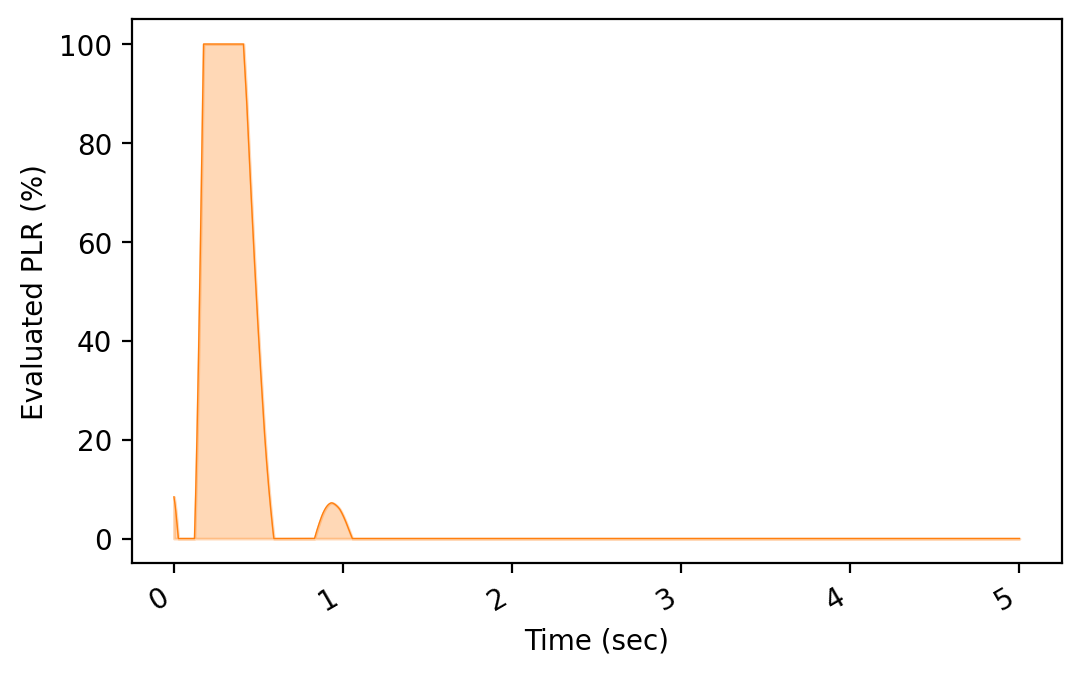

In [34]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y1 = poly_approx(x, 'SCG_Failure_t310-Expiry (0)', center=1)
y2 = poly_approx(x, 'MCG_Failure_otherFailure (2)', center=3)
y = [s1*s2 for (s1, s2) in zip(y1, y2)]
y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', np.mean(y[i*SPR:(i+1)*SPR]), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
plt.gcf().autofmt_xdate()
plt.show()